# TRUE Curriculum Learning for Modular Addition

This notebook implements **genuine curriculum learning** where each stage is a proper subset of the next.

## The Key Difference

**Previous approach (NOT true curriculum):**
- Stage 1: `(a+b) % 8` where `a,b ∈ [0,7]`
- Stage 2: `(a+b) % 16` where `a,b ∈ [0,15]`
- Problem: Different functions! `(5+7) % 8 ≠ (5+7) % 16`

**True curriculum (this notebook):**
- Stage 1: `(a+b) % 64` where `a,b ∈ [0,7]` → 64 pairs
- Stage 2: `(a+b) % 64` where `a,b ∈ [0,15]` → 256 pairs
- Stage 3: `(a+b) % 64` where `a,b ∈ [0,31]` → 1024 pairs
- Stage 4: `(a+b) % 64` where `a,b ∈ [0,63]` → 4096 pairs
- ✅ Stage 1 is a TRUE subset of Stage 2, etc.

## Benefits

1. **Same task throughout** - Always computing `(a+b) % 64`
2. **Same vocabulary** - Always 64 tokens, no embedding resizing!
3. **Full weight transfer** - 100% of weights transfer between stages
4. **Progressive difficulty** - More pairs to learn at each stage
5. **True subsets** - Earlier stages literally contained in later stages

## Research Question

Does learning on progressively larger subsets of the full task lead to:
- Better generalization?
- Different LLC trajectories?
- Faster convergence?
- Better final performance?

Compared to learning on the full task directly.

## 1. Setup

In [1]:
%pip install devinterp scipy

import random
from copy import deepcopy
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from pathlib import Path
from scipy import stats

from devinterp.optim.sgld import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import evaluate_ce

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
RESULTS_DIR = Path("../results/true_curriculum")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

def save_fig(fig, name):
    fig.savefig(RESULTS_DIR / name, dpi=300, bbox_inches='tight')
    print(f"Saved: {name}")
    plt.show()

print(f"Device: {DEVICE}")
print(f"Results dir: {RESULTS_DIR}")

/home/dorian/Projects/llc/venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.
Device: cuda
Results dir: ../results/true_curriculum


## 2. Experiment Parameters

**Key**: Fixed vocabulary size of 64 throughout all stages!

In [2]:
@dataclass
class Params:
    p: int = 64  # FIXED vocabulary size
    n_batches_per_stage: int = 50000
    n_checkpoints: int = 100
    print_times: int = 100
    lr: float = 0.005
    batch_size: int = 128
    hidden_size: int = 48
    embed_dim: int = 12
    train_frac: float = 0.4
    weight_decay: float = 0.0002
    device: str = DEVICE

# Curriculum: progressively expand input range (all compute % 64)
INPUT_RANGES = [ 
    7,   # Stage 1: a,b ∈ [0,7]   → 8×8 = 64 pairs
    15,  # Stage 2: a,b ∈ [0,15]  → 16×16 = 256 pairs
    31,  # Stage 3: a,b ∈ [0,31]  → 32×32 = 1024 pairs
    63,  # Stage 4: a,b ∈ [0,63]  → 64×64 = 4096 pairs
]

MODULUS = 64  # Fixed modulus for all stages. For more complicated curricula, use larger final modulus and subset ranges.
SEEDS = [0]

print("Curriculum stages:")
for i, max_val in enumerate(INPUT_RANGES):
    n_pairs = (max_val + 1) ** 2
    print(f"  Stage {i+1}: a,b ∈ [0,{max_val}] → {n_pairs} pairs, compute (a+b) % {MODULUS}")

total_curriculum_batches = len(INPUT_RANGES) * 50000
print(f"\nTotal curriculum batches: {total_curriculum_batches:,}")
print(f"Direct training batches: {total_curriculum_batches:,} (equalized)")
print(f"Seeds: {SEEDS}")

Curriculum stages:
  Stage 1: a,b ∈ [0,7] → 64 pairs, compute (a+b) % 64
  Stage 2: a,b ∈ [0,15] → 256 pairs, compute (a+b) % 64
  Stage 3: a,b ∈ [0,31] → 1024 pairs, compute (a+b) % 64
  Stage 4: a,b ∈ [0,63] → 4096 pairs, compute (a+b) % 64

Total curriculum batches: 200,000
Direct training batches: 200,000 (equalized)
Seeds: [0]


## 3. Model and Training Functions

In [3]:
class MLP(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.embedding = nn.Embedding(params.p, params.embed_dim)
        self.linear1r = nn.Linear(params.embed_dim, params.hidden_size, bias=True)
        self.linear1l = nn.Linear(params.embed_dim, params.hidden_size, bias=True)
        self.linear2 = nn.Linear(params.hidden_size, params.p, bias=False)
        self.act = nn.GELU()
        self.vocab_size = params.p

    def forward(self, x):
        x = x.to(self.embedding.weight.device)
        x1 = self.embedding(x[..., 0])
        x2 = self.embedding(x[..., 1])
        x1 = self.linear1l(x1)
        x2 = self.linear1r(x2)
        x = x1 + x2
        x = self.act(x)
        x = self.linear2(x)
        return x

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def test(model, dataset, device):
    n_correct = 0
    total_loss = 0
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x, y in dataset:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = loss_fn(out, y)
            total_loss += loss.item()
            pred = torch.argmax(out, dim=-1)
            if pred == y:
                n_correct += 1
    return n_correct / len(dataset), total_loss / len(dataset)

def train(train_dataset, test_dataset, params, model=None, verbose=True):
    all_models = []
    if model is None:
        model = MLP(params).to(params.device)
    
    optimizer = torch.optim.Adam(
        model.parameters(), weight_decay=params.weight_decay, lr=params.lr
    )
    loss_fn = nn.CrossEntropyLoss()
    train_loader = DataLoader(train_dataset, batch_size=params.batch_size, shuffle=True)
    
    print_every = params.n_batches_per_stage // params.print_times
    checkpoint_every = params.n_batches_per_stage // params.n_checkpoints
    
    loss_data = []
    if verbose:
        pbar = tqdm(total=params.n_batches_per_stage, desc="Training")
    
    for i in range(params.n_batches_per_stage):
        batch = next(iter(train_loader))
        X, Y = batch
        X, Y = X.to(params.device), Y.to(params.device)
        
        optimizer.zero_grad()
        out = model(X)
        loss = loss_fn(out, Y)
        loss.backward()
        optimizer.step()
        
        if (i + 1) % checkpoint_every == 0:
            all_models.append(deepcopy(model))
        
        if (i + 1) % print_every == 0:
            val_acc, val_loss = test(model, test_dataset, params.device)
            train_acc, train_loss = test(model, train_dataset, params.device)
            loss_data.append({
                "batch": i + 1,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc,
            })
            if verbose:
                pbar.set_postfix({
                    "train_loss": f"{train_loss:.4f}",
                    "train_acc": f"{train_acc:.4f}",
                    "val_loss": f"{val_loss:.4f}",
                    "val_acc": f"{val_acc:.4f}",
                })
                pbar.update(print_every)
    
    if verbose:
        pbar.close()
    
    df = pd.DataFrame(loss_data)
    train_acc, train_loss = test(model, train_dataset, params.device)
    val_acc, val_loss = test(model, test_dataset, params.device)
    
    if verbose:
        print(f"Final Train: {train_acc:.4f} acc, {train_loss:.4f} loss")
        print(f"Final Val:   {val_acc:.4f} acc, {val_loss:.4f} loss")
    
    return all_models, df

print("Model and training functions defined!")

Model and training functions defined!


## 4. Dataset Generation - Key Innovation!

**Critical**: All stages compute `(a+b) % 64`, but with restricted input ranges

In [4]:
def make_curriculum_dataset(max_input_value, modulus=64):
    """
    Create dataset where a,b ∈ [0, max_input_value] but compute (a+b) % modulus.
    
    Example:
        max_input_value=7, modulus=64 → pairs like (3,5) with label (3+5)%64=8
    
    This ensures:
    - Same modulus (64) throughout
    - Progressive difficulty (more pairs to learn)
    - True subsets (stage 1 pairs ⊂ stage 2 pairs ⊂ ...)
    """
    data = []
    for a in range(max_input_value + 1):
        for b in range(max_input_value + 1):
            x = torch.tensor([a, b])
            y = torch.tensor((a + b) % modulus)
            data.append((x, y))
    return data

def train_test_split(dataset, train_frac, seed):
    """Split dataset deterministically."""
    n = len(dataset)
    n_train = int(train_frac * n)
    indices = list(range(n))
    
    rng = random.Random(seed)
    rng.shuffle(indices)
    
    train_idx = indices[:n_train]
    test_idx = indices[n_train:]
    
    return [dataset[i] for i in train_idx], [dataset[i] for i in test_idx]

# Create full dataset first, then subset for curriculum stages
full_dataset = make_curriculum_dataset(63, modulus=MODULUS)
direct_train, direct_test = train_test_split(full_dataset, train_frac=0.4, seed=0)
print(f"Direct (full): {len(full_dataset)} total, {len(direct_train)} train, {len(direct_test)} test")

# Create curriculum datasets by filtering the full train/test splits
curriculum_data = {}
for max_val in INPUT_RANGES:
    # Filter train set: keep only pairs where both a,b <= max_val
    train_data = [(x, y) for x, y in direct_train
                  if x[0].item() <= max_val and x[1].item() <= max_val]
    
    # Filter test set: keep only pairs where both a,b <= max_val
    test_data = [(x, y) for x, y in direct_test
                 if x[0].item() <= max_val and x[1].item() <= max_val]
    
    curriculum_data[max_val] = {'train': train_data, 'test': test_data}
    total = len(train_data) + len(test_data)
    print(f"Range [0,{max_val}]: {total} total, {len(train_data)} train, {len(test_data)} test")

# VERIFY: Stage 1 is subset of Stage 2
stage1_pairs = set((x[0].item(), x[1].item()) for x, _ in curriculum_data[7]['train'])
stage2_pairs = set((x[0].item(), x[1].item()) for x, _ in curriculum_data[15]['train'])
stage3_pairs = set((x[0].item(), x[1].item()) for x, _ in curriculum_data[31]['train'])
stage4_pairs = set((x[0].item(), x[1].item()) for x, _ in curriculum_data[63]['train'])

print(f"\n✅ Verification: Stage 1 ⊆ Stage 2? {stage1_pairs.issubset(stage2_pairs)}")
print(f"✅ Verification: Stage 2 ⊆ Stage 3? {stage2_pairs.issubset(stage3_pairs)}")
print(f"✅ Verification: Stage 3 ⊆ Stage 4? {stage3_pairs.issubset(stage4_pairs)}")
print(f"\n   Stage 1 has {len(stage1_pairs)} pairs")
print(f"   Stage 2 has {len(stage2_pairs)} pairs")
print(f"   Stage 3 has {len(stage3_pairs)} pairs")
print(f"   Stage 4 has {len(stage4_pairs)} pairs")

Direct (full): 4096 total, 1638 train, 2458 test
Range [0,7]: 64 total, 27 train, 37 test
Range [0,15]: 256 total, 97 train, 159 test
Range [0,31]: 1024 total, 417 train, 607 test
Range [0,63]: 4096 total, 1638 train, 2458 test

✅ Verification: Stage 1 ⊆ Stage 2? True
✅ Verification: Stage 2 ⊆ Stage 3? True
✅ Verification: Stage 3 ⊆ Stage 4? True

   Stage 1 has 27 pairs
   Stage 2 has 97 pairs
   Stage 3 has 417 pairs
   Stage 4 has 1638 pairs


## 5. Run Curriculum Learning

**Key advantage**: Same model architecture throughout, 100% weight transfer!

In [5]:
curriculum_results = {}  # {seed: {stage: {checkpoints, df}}}

for seed in SEEDS:
    print("\n" + "="*80)
    print(f"CURRICULUM LEARNING - SEED {seed}")
    print("="*80)
    
    set_seed(seed)
    curriculum_results[seed] = {}
    model = None  # Will be created in first stage
    
    for stage_idx, max_val in enumerate(INPUT_RANGES):
        print(f"\nStage {stage_idx+1}/{len(INPUT_RANGES)}: Inputs [0,{max_val}], output % {MODULUS}")
        
        params = Params()
        train_data = [(x.to(DEVICE), y.to(DEVICE)) for x, y in curriculum_data[max_val]['train']]
        test_data = [(x.to(DEVICE), y.to(DEVICE)) for x, y in curriculum_data[max_val]['test']]
        
        # Train (model=None for first stage, then reuse)
        checkpoints, df = train(train_data, test_data, params, model=model, verbose=True)
        curriculum_results[seed][max_val] = {'checkpoints': checkpoints, 'df': df}
        
        # Use final checkpoint as starting point for next stage
        # BUG FIX: Use deepcopy to avoid modifying the stored checkpoint!
        model = deepcopy(checkpoints[-1])
        
        if stage_idx == 0:
            print(f"\n✅ Stage 1 complete. Model created with vocab_size={params.p}")
            print(f"   This SAME model will be used for all stages (100% weight transfer!)")

print("\n" + "="*80)
print("✅ Curriculum learning complete for all seeds!")
print("="*80)


CURRICULUM LEARNING - SEED 0

Stage 1/4: Inputs [0,7], output % 64


Training: 100%|██████████| 50000/50000 [00:35<00:00, 1402.36it/s, train_loss=0.0012, train_acc=1.0000, val_loss=10.7298, val_acc=0.0270]


Final Train: 1.0000 acc, 0.0012 loss
Final Val:   0.0270 acc, 10.7298 loss

✅ Stage 1 complete. Model created with vocab_size=64
   This SAME model will be used for all stages (100% weight transfer!)

Stage 2/4: Inputs [0,15], output % 64


Training: 100%|██████████| 50000/50000 [00:38<00:00, 1314.34it/s, train_loss=0.0033, train_acc=1.0000, val_loss=9.2305, val_acc=0.0189]


Final Train: 1.0000 acc, 0.0033 loss
Final Val:   0.0189 acc, 9.2305 loss

Stage 3/4: Inputs [0,31], output % 64


Training: 100%|██████████| 50000/50000 [00:46<00:00, 1080.74it/s, train_loss=0.0085, train_acc=1.0000, val_loss=1.1729, val_acc=0.7183]


Final Train: 1.0000 acc, 0.0085 loss
Final Val:   0.7183 acc, 1.1729 loss

Stage 4/4: Inputs [0,63], output % 64


Training: 100%|██████████| 50000/50000 [01:23<00:00, 599.06it/s, train_loss=0.0155, train_acc=1.0000, val_loss=0.0784, val_acc=0.9890]


Final Train: 1.0000 acc, 0.0155 loss
Final Val:   0.9890 acc, 0.0784 loss

✅ Curriculum learning complete for all seeds!


## 6. Run Direct Training (Equalized Budget)

In [6]:
direct_results = {}

for seed in SEEDS:
    print("\n" + "="*80)
    print(f"DIRECT TRAINING - SEED {seed}")
    print("="*80)
    
    set_seed(seed)
    params = Params()
    params.n_batches_per_stage = len(INPUT_RANGES) * 50000  # 200k batches!
    
    train_data = [(x.to(DEVICE), y.to(DEVICE)) for x, y in direct_train]
    test_data = [(x.to(DEVICE), y.to(DEVICE)) for x, y in direct_test]
    
    checkpoints, df = train(train_data, test_data, params, model=None, verbose=True)
    direct_results[seed] = {'checkpoints': checkpoints, 'df': df}

print("\n" + "="*80)
print("✅ Direct training complete for all seeds!")
print("="*80)


DIRECT TRAINING - SEED 0


Training: 100%|██████████| 200000/200000 [03:22<00:00, 987.33it/s, train_loss=0.0143, train_acc=1.0000, val_loss=0.0375, val_acc=1.0000]  


Final Train: 1.0000 acc, 0.0143 loss
Final Val:   1.0000 acc, 0.0375 loss

✅ Direct training complete for all seeds!


## 7. Analysis and Visualization

Saved: true_curriculum_vs_direct_accuracy.png


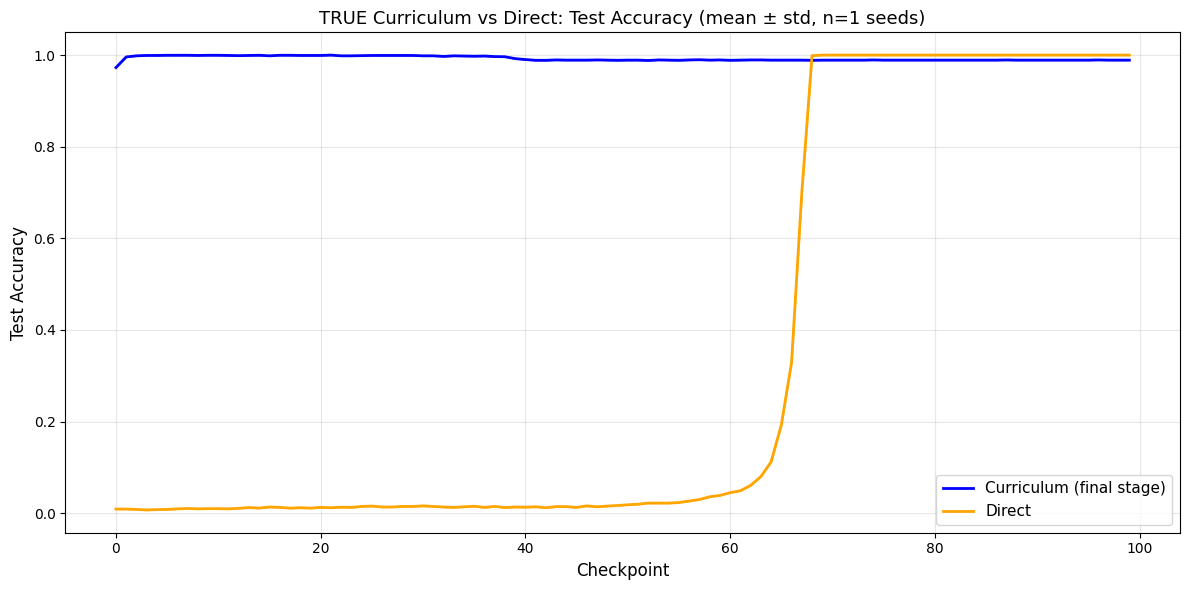


FINAL ACCURACY SUMMARY
Curriculum final acc: 0.9890 ± 0.0000
Direct final acc:     1.0000 ± 0.0000


In [7]:
# Aggregate curriculum final stage across seeds
curriculum_final_accs = []
curriculum_final_losses = []
for seed in SEEDS:
    df = curriculum_results[seed][INPUT_RANGES[-1]]['df']
    curriculum_final_accs.append(df['val_acc'].values)
    curriculum_final_losses.append(df['val_loss'].values)

# Aggregate direct across seeds
direct_accs = []
direct_losses = []
for seed in SEEDS:
    df = direct_results[seed]['df']
    direct_accs.append(df['val_acc'].values)
    direct_losses.append(df['val_loss'].values)

# Compute mean and std
min_len_curr = min(len(a) for a in curriculum_final_accs)
min_len_direct = min(len(a) for a in direct_accs)

curr_acc_mean = np.mean([a[:min_len_curr] for a in curriculum_final_accs], axis=0)
curr_acc_std = np.std([a[:min_len_curr] for a in curriculum_final_accs], axis=0)
direct_acc_mean = np.mean([a[:min_len_direct] for a in direct_accs], axis=0)
direct_acc_std = np.std([a[:min_len_direct] for a in direct_accs], axis=0)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
x_curr = np.arange(len(curr_acc_mean))
x_direct = np.arange(len(direct_acc_mean))

ax.plot(x_curr, curr_acc_mean, label='Curriculum (final stage)', color='blue', linewidth=2)
ax.fill_between(x_curr, curr_acc_mean - curr_acc_std, curr_acc_mean + curr_acc_std, 
                alpha=0.3, color='blue')

ax.plot(x_direct, direct_acc_mean, label='Direct', color='orange', linewidth=2)
ax.fill_between(x_direct, direct_acc_mean - direct_acc_std, direct_acc_mean + direct_acc_std,
                alpha=0.3, color='orange')

ax.set_xlabel('Checkpoint', fontsize=12)
ax.set_ylabel('Test Accuracy', fontsize=12)
ax.set_title(f'TRUE Curriculum vs Direct: Test Accuracy (mean ± std, n={len(SEEDS)} seeds)', fontsize=13)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
save_fig(fig, 'true_curriculum_vs_direct_accuracy.png')

# Print final accuracy summary
curr_final = [df['val_acc'].iloc[-1] for seed in SEEDS for df in [curriculum_results[seed][INPUT_RANGES[-1]]['df']]]
direct_final = [df['val_acc'].iloc[-1] for seed in SEEDS for df in [direct_results[seed]['df']]]

print("\n" + "="*80)
print("FINAL ACCURACY SUMMARY")
print("="*80)
print(f"Curriculum final acc: {np.mean(curr_final):.4f} ± {np.std(curr_final):.4f}")
print(f"Direct final acc:     {np.mean(direct_final):.4f} ± {np.std(direct_final):.4f}")
print("="*80)

## 8. Local Learning Coefficient (LLC) Analysis

Now we estimate the LLC for all checkpoints to understand how model complexity evolves during curriculum vs direct training.

Testing LLC estimation on final curriculum checkpoint (seed 0)...


/home/dorian/Projects/llc/venv/lib/python3.12/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/home/dorian/Projects/llc/venv/lib/python3.12/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/home/dorian/Projects/llc/venv/lib/python3.12/site-packages/devinterp/backends/default/slt/sampler.py:244: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be [B, A, C, B, A, C, B, A, C].)
  warnings.warn(
/home/dorian/Projects/llc/venv/lib/python3.12/site-packages/devinterp/backends/default/slt/

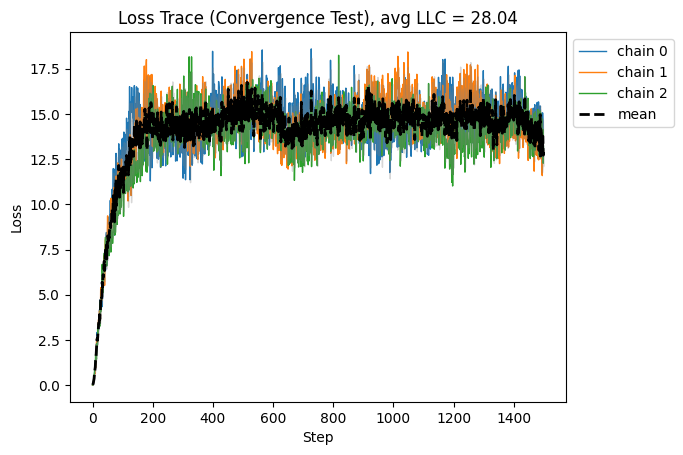

<Figure size 1200x600 with 0 Axes>


Average LLC: 28.04
If the loss trace flattens out, hyperparameters are good.


In [8]:
# LLC hyperparameters (from devinterp grokking example)
llc_lr = 3e-3  # epsilon
llc_nbeta = 2.0
llc_gamma = 5.0  # localization
llc_num_chains = 1  # Use 1 chain for individual checkpoint estimation
llc_num_draws = 1000

# Test LLC estimation on one checkpoint to verify convergence
print("Testing LLC estimation on final curriculum checkpoint (seed 0)...")
seed = SEEDS[0]
final_stage_checkpoints = curriculum_results[seed][INPUT_RANGES[-1]]['checkpoints']
train_data = [(x.to(DEVICE), y.to(DEVICE)) for x, y in curriculum_data[INPUT_RANGES[-1]]['train']]
loader = DataLoader(train_data, batch_size=Params().batch_size, shuffle=True)

test_llc_stats = estimate_learning_coeff_with_summary(
    final_stage_checkpoints[-1],
    loader=loader,
    evaluate=evaluate_ce,
    sampling_method=SGLD,
    optimizer_kwargs=dict(lr=llc_lr, nbeta=llc_nbeta, localization=llc_gamma),
    num_chains=3,  # Use more chains for verification
    num_draws=1500,
    device=DEVICE,
    online=True,  # Get loss/trace for visualization
)

# Plot loss trace
from devinterp.utils import plot_trace
trace = test_llc_stats["loss/trace"]
avg_llc = sum(test_llc_stats['llc/means']) / len(test_llc_stats['llc/means'])

plot_trace(
    trace,
    "Loss",
    x_axis="Step",
    title=f"Loss Trace (Convergence Test), avg LLC = {avg_llc:.2f}",
    plot_mean=False,
    plot_std=False,
    fig_size=(12, 6),
    true_lc=None,
)
print(f"\nAverage LLC: {avg_llc:.2f}")
print("If the loss trace flattens out, hyperparameters are good.")

In [9]:
# Estimate LLC for all curriculum checkpoints (ALL seeds)
print("\n" + "="*80)
print("Estimating LLC for curriculum checkpoints (all seeds)...")
print("="*80)

curriculum_llcs_by_seed = {}  # {seed: [stage1_llcs, stage2_llcs, ...]}

for seed in SEEDS:
    print(f"\n{'='*80}")
    print(f"SEED {seed}")
    print('='*80)
    
    curriculum_llcs_by_seed[seed] = []
    
    for stage_idx, max_val in enumerate(INPUT_RANGES):
        print(f"\nStage {stage_idx+1}/{len(INPUT_RANGES)}: [0,{max_val}]")
        
        checkpoints = curriculum_results[seed][max_val]['checkpoints']
        train_data = [(x.to(DEVICE), y.to(DEVICE)) for x, y in curriculum_data[max_val]['train']]
        loader = DataLoader(train_data, batch_size=Params().batch_size, shuffle=True)
        
        print(f"  Estimating LLC for {len(checkpoints)} checkpoints...")
        
        stage_llcs = []
        for checkpoint_idx, model_checkpoint in enumerate(checkpoints):
            if (checkpoint_idx + 1) % 20 == 0 or checkpoint_idx == 0 or checkpoint_idx == len(checkpoints) - 1:
                print(f"    Checkpoint {checkpoint_idx+1}/{len(checkpoints)}")
            
            llc_stats = estimate_learning_coeff_with_summary(
                model_checkpoint,
                loader=loader,
                evaluate=evaluate_ce,
                sampling_method=SGLD,
                optimizer_kwargs=dict(lr=llc_lr, nbeta=llc_nbeta, localization=llc_gamma),
                num_chains=llc_num_chains,
                num_draws=llc_num_draws,
                device=DEVICE,
                online=False,
            )
            stage_llcs.append(llc_stats)
        
        curriculum_llcs_by_seed[seed].append(stage_llcs)
        llc_range = [llc['llc/mean'] for llc in stage_llcs]
        print(f"  LLC range: [{min(llc_range):.2f}, {max(llc_range):.2f}]")

print("\n" + "="*80)
print("Curriculum LLC estimation complete for all seeds!")
print("="*80)

# Create aggregated version for plotting (backward compatibility)
curriculum_llcs_by_stage = curriculum_llcs_by_seed[SEEDS[0]]


Estimating LLC for curriculum checkpoints (all seeds)...

SEED 0

Stage 1/4: [0,7]
  Estimating LLC for 100 checkpoints...
    Checkpoint 1/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1096.38it/s]
/home/dorian/Projects/llc/venv/lib/python3.12/site-packages/devinterp/slt/llc.py:109: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  self.llc_std = self.llc_per_chain.std()
Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1248.20it/s]


    Checkpoint 20/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1039.94it/s]


    Checkpoint 40/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1259.59it/s]


    Checkpoint 60/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1160.33it/s]


    Checkpoint 80/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1207.83it/s]


    Checkpoint 100/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1237.03it/s]


  LLC range: [5.58, 11.14]

Stage 2/4: [0,15]
  Estimating LLC for 100 checkpoints...
    Checkpoint 1/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1054.30it/s]


    Checkpoint 20/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1179.60it/s]


    Checkpoint 40/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1082.24it/s]


    Checkpoint 60/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1126.39it/s]


    Checkpoint 80/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1035.54it/s]


    Checkpoint 100/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1024.01it/s]


  LLC range: [13.03, 16.68]

Stage 3/4: [0,31]
  Estimating LLC for 100 checkpoints...
    Checkpoint 1/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1039.71it/s]


    Checkpoint 20/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1134.25it/s]


    Checkpoint 40/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1045.36it/s]


    Checkpoint 60/100


Chain 0: 100%|██████████| 1000/1000 [00:01<00:00, 861.92it/s]


    Checkpoint 80/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1111.65it/s]


    Checkpoint 100/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1147.34it/s]


  LLC range: [20.78, 31.73]

Stage 4/4: [0,63]
  Estimating LLC for 100 checkpoints...
    Checkpoint 1/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1030.09it/s]


    Checkpoint 20/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1145.31it/s]


    Checkpoint 40/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1064.66it/s]


    Checkpoint 60/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1030.35it/s]


    Checkpoint 80/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1120.25it/s]


    Checkpoint 100/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1153.46it/s]

  LLC range: [26.09, 29.26]

Curriculum LLC estimation complete for all seeds!


In [10]:
# Estimate LLC for all direct training checkpoints (ALL seeds)
print("\n" + "="*80)
print("Estimating LLC for direct training checkpoints (all seeds)...")
print("="*80)

direct_llcs_by_seed = {}

for seed in SEEDS:
    print(f"\n{'='*80}")
    print(f"SEED {seed}")
    print('='*80)
    
    checkpoints = direct_results[seed]['checkpoints']
    train_data = [(x.to(DEVICE), y.to(DEVICE)) for x, y in direct_train]
    loader = DataLoader(train_data, batch_size=Params().batch_size, shuffle=True)
    
    print(f"Total checkpoints: {len(checkpoints)}")
    
    seed_llcs = []
    for checkpoint_idx, model_checkpoint in enumerate(checkpoints):
        if (checkpoint_idx + 1) % 20 == 0 or checkpoint_idx == 0 or checkpoint_idx == len(checkpoints) - 1:
            print(f"  Checkpoint {checkpoint_idx+1}/{len(checkpoints)}")
        
        llc_stats = estimate_learning_coeff_with_summary(
            model_checkpoint,
            loader=loader,
            evaluate=evaluate_ce,
            sampling_method=SGLD,
            optimizer_kwargs=dict(lr=llc_lr, nbeta=llc_nbeta, localization=llc_gamma),
            num_chains=llc_num_chains,
            num_draws=llc_num_draws,
            device=DEVICE,
            online=False,
        )
        seed_llcs.append(llc_stats)
    
    direct_llcs_by_seed[seed] = seed_llcs
    llc_range = [llc['llc/mean'] for llc in seed_llcs]
    print(f"\nLLC range: [{min(llc_range):.2f}, {max(llc_range):.2f}]")

print("\n" + "="*80)
print("Direct LLC estimation complete for all seeds!")
print("="*80)

# Create aggregated version for plotting (backward compatibility)
direct_llcs = direct_llcs_by_seed[SEEDS[0]]


Estimating LLC for direct training checkpoints (all seeds)...

SEED 0
Total checkpoints: 100
  Checkpoint 1/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1008.03it/s]


  Checkpoint 20/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1084.82it/s]


  Checkpoint 40/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1085.19it/s]


  Checkpoint 60/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1126.51it/s]


  Checkpoint 80/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1009.75it/s]


  Checkpoint 100/100


Chain 0: 100%|██████████| 1000/1000 [00:00<00:00, 1047.90it/s]


LLC range: [24.15, 56.62]

Direct LLC estimation complete for all seeds!


## 9. LLC Visualization

Saved: curriculum_llc_vs_accuracy.png


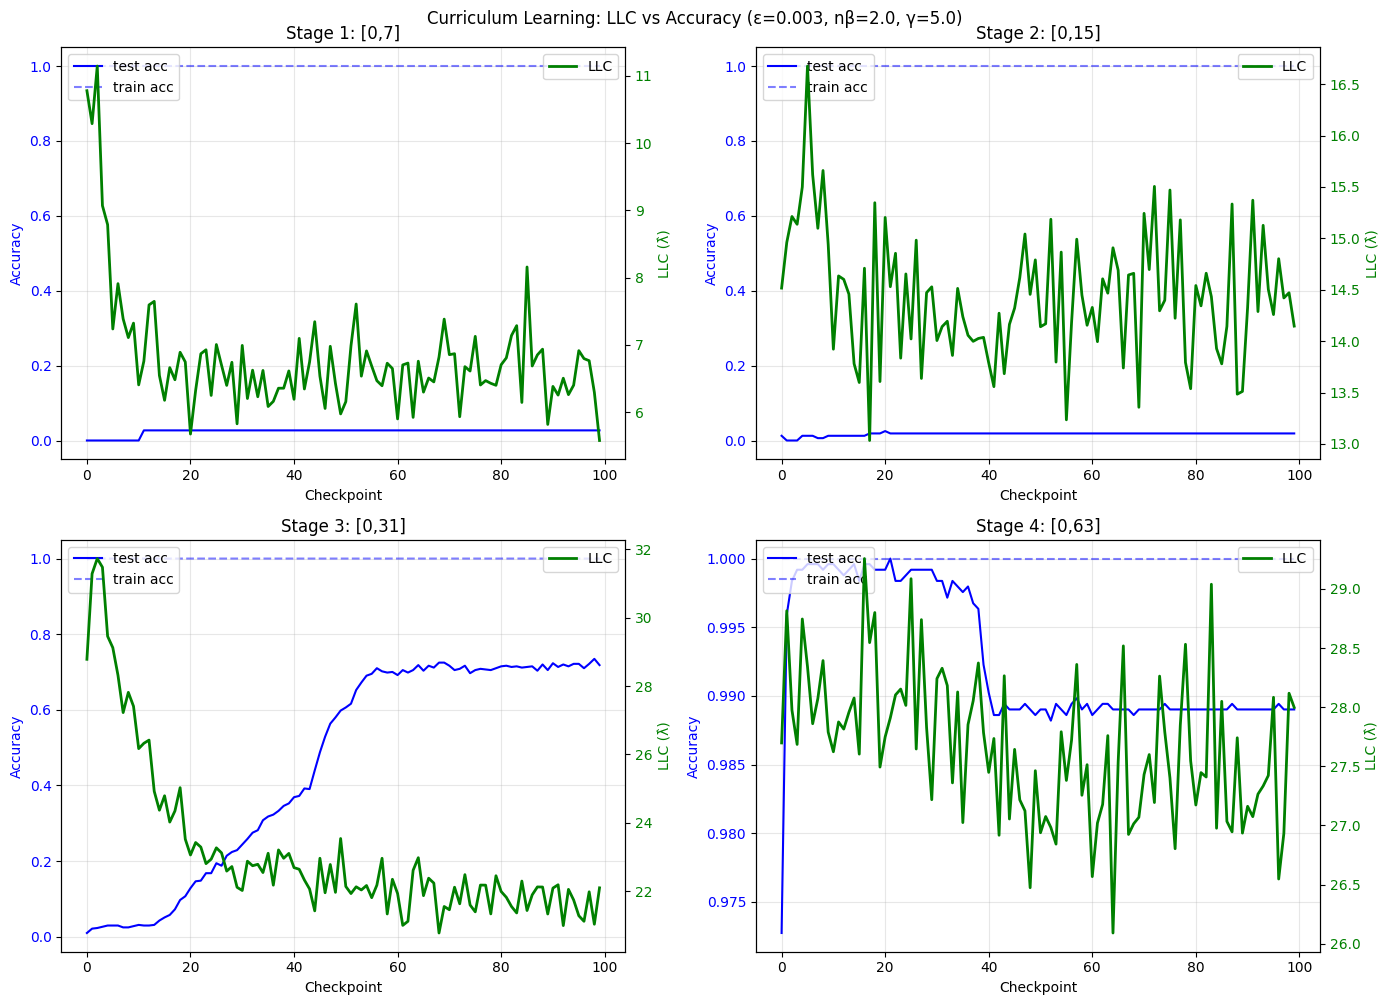

In [11]:
# Plot LLC vs Accuracy for each curriculum stage (seed 0)
seed = SEEDS[0]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for stage_idx, (stage_llcs, max_val) in enumerate(zip(curriculum_llcs_by_seed[seed], INPUT_RANGES)):
    ax1 = axes[stage_idx]
    ax2 = ax1.twinx()
    
    df = curriculum_results[seed][max_val]['df']
    
    # Plot accuracy
    ax1.plot(df["val_acc"], label="test acc", color='blue')
    ax1.plot(df["train_acc"], label="train acc", color='blue', linestyle='--', alpha=0.5)
    
    # Plot LLC
    llc_values = [llc["llc/mean"] for llc in stage_llcs]
    ax2.plot(llc_values, color='green', label="LLC", linewidth=2)
    
    ax1.set_xlabel("Checkpoint")
    ax1.set_ylabel("Accuracy", color='blue')
    ax2.set_ylabel("LLC (λ̂)", color='green')
    ax1.set_title(f"Stage {stage_idx+1}: [0,{max_val}]")
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2.tick_params(axis='y', labelcolor='green')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle(f"Curriculum Learning: LLC vs Accuracy (ε={llc_lr}, nβ={llc_nbeta}, γ={llc_gamma})", y=1.00)
save_fig(fig, 'curriculum_llc_vs_accuracy.png')

Saved: curriculum_llc_vs_loss.png


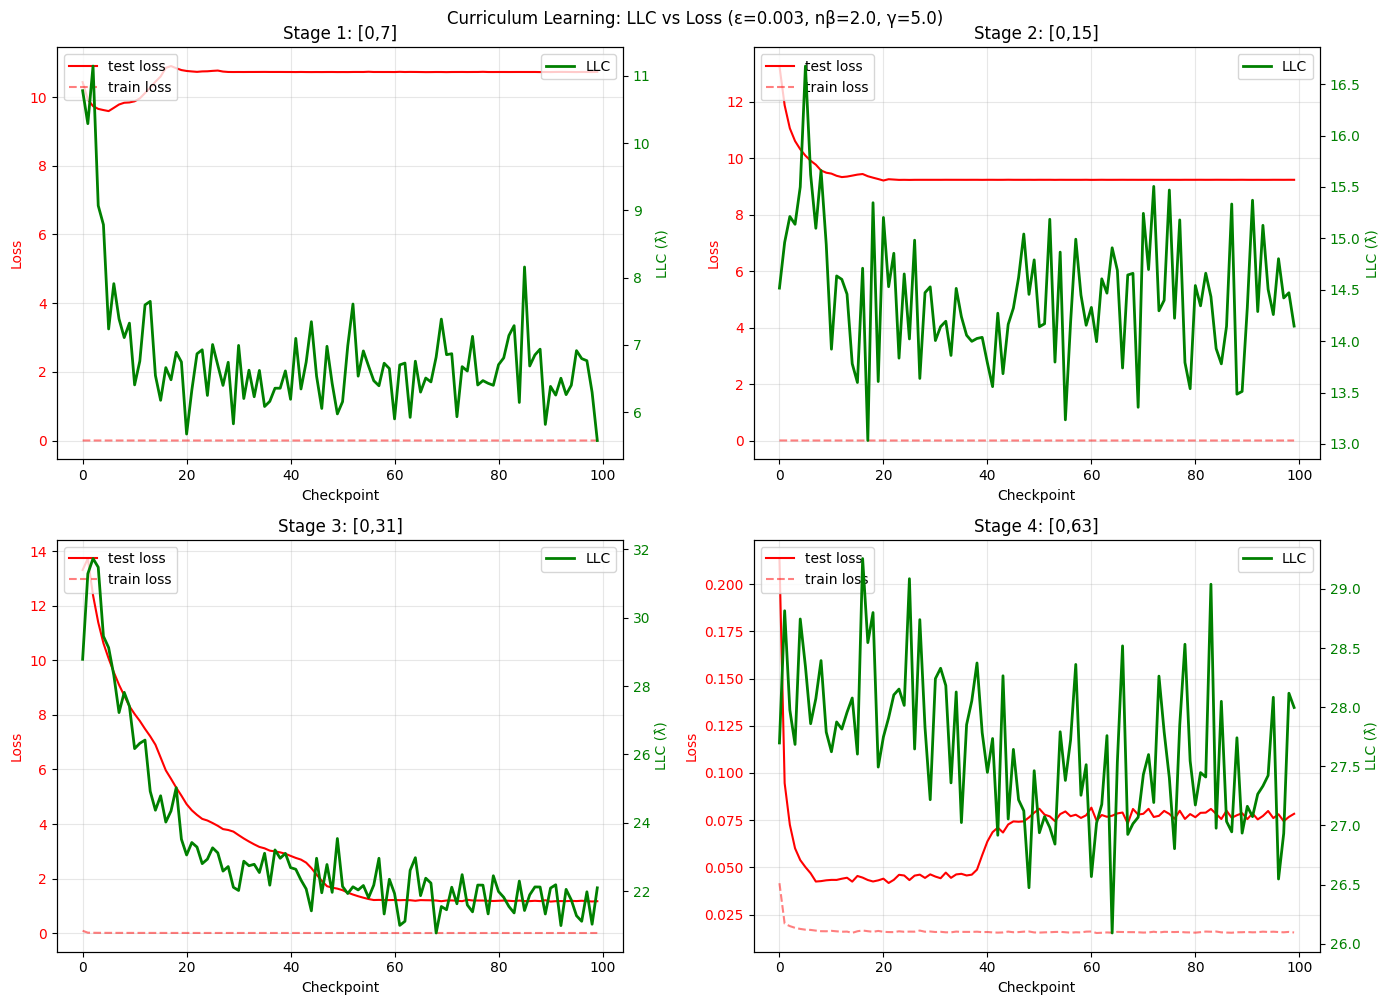

In [12]:
# Plot LLC vs Loss for each curriculum stage (seed 0)
seed = SEEDS[0]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for stage_idx, (stage_llcs, max_val) in enumerate(zip(curriculum_llcs_by_seed[seed], INPUT_RANGES)):
    ax1 = axes[stage_idx]
    ax2 = ax1.twinx()
    
    df = curriculum_results[seed][max_val]['df']
    
    # Plot loss
    ax1.plot(df["val_loss"], label="test loss", color='red')
    ax1.plot(df["train_loss"], label="train loss", color='red', linestyle='--', alpha=0.5)
    
    # Plot LLC
    llc_values = [llc["llc/mean"] for llc in stage_llcs]
    ax2.plot(llc_values, color='green', label="LLC", linewidth=2)
    
    ax1.set_xlabel("Checkpoint")
    ax1.set_ylabel("Loss", color='red')
    ax2.set_ylabel("LLC (λ̂)", color='green')
    ax1.set_title(f"Stage {stage_idx+1}: [0,{max_val}]")
    ax1.tick_params(axis='y', labelcolor='red')
    ax2.tick_params(axis='y', labelcolor='green')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle(f"Curriculum Learning: LLC vs Loss (ε={llc_lr}, nβ={llc_nbeta}, γ={llc_gamma})", y=1.00)
save_fig(fig, 'curriculum_llc_vs_loss.png')

Saved: direct_llc_vs_accuracy.png


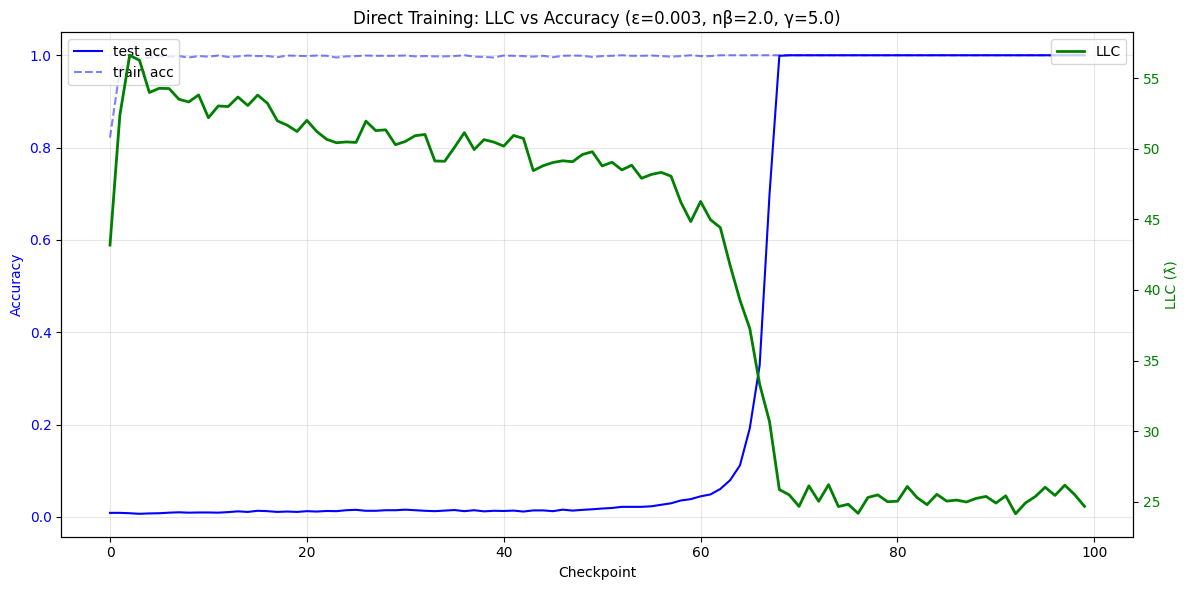

In [13]:
# Plot Direct Training: LLC vs Accuracy (seed 0)
seed = SEEDS[0]
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

df = direct_results[seed]['df']

# Plot accuracy
ax1.plot(df["val_acc"], label="test acc", color='blue')
ax1.plot(df["train_acc"], label="train acc", color='blue', linestyle='--', alpha=0.5)

# Plot LLC
llc_values = [llc["llc/mean"] for llc in direct_llcs_by_seed[seed]]
ax2.plot(llc_values, color='green', label="LLC", linewidth=2)

ax1.set_xlabel("Checkpoint")
ax1.set_ylabel("Accuracy", color='blue')
ax2.set_ylabel("LLC (λ̂)", color='green')
ax1.set_title(f"Direct Training: LLC vs Accuracy (ε={llc_lr}, nβ={llc_nbeta}, γ={llc_gamma})")
ax1.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='green')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
plt.tight_layout()
save_fig(fig, 'direct_llc_vs_accuracy.png')

Saved: direct_llc_vs_loss.png


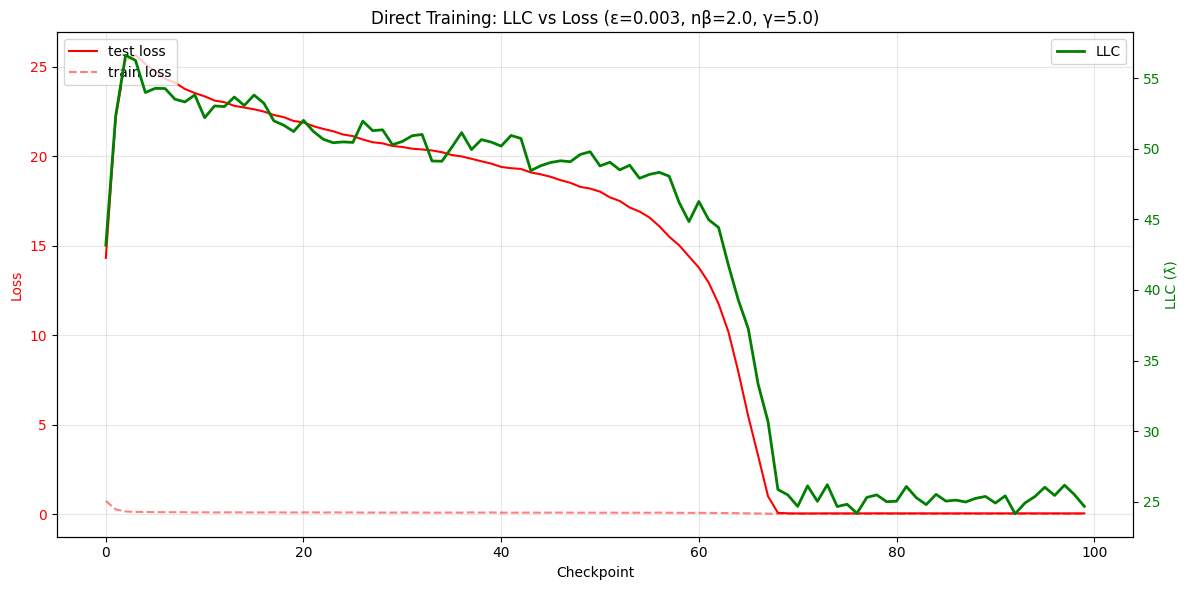

In [14]:
# Plot Direct Training: LLC vs Loss (seed 0)
seed = SEEDS[0]
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

df = direct_results[seed]['df']

# Plot loss
ax1.plot(df["val_loss"], label="test loss", color='red')
ax1.plot(df["train_loss"], label="train loss", color='red', linestyle='--', alpha=0.5)

# Plot LLC
llc_values = [llc["llc/mean"] for llc in direct_llcs_by_seed[seed]]
ax2.plot(llc_values, color='green', label="LLC", linewidth=2)

ax1.set_xlabel("Checkpoint")
ax1.set_ylabel("Loss", color='red')
ax2.set_ylabel("LLC (λ̂)", color='green')
ax1.set_title(f"Direct Training: LLC vs Loss (ε={llc_lr}, nβ={llc_nbeta}, γ={llc_gamma})")
ax1.tick_params(axis='y', labelcolor='red')
ax2.tick_params(axis='y', labelcolor='green')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
plt.tight_layout()
save_fig(fig, 'direct_llc_vs_loss.png')

Saved: curriculum_vs_direct_accuracy_llc.png


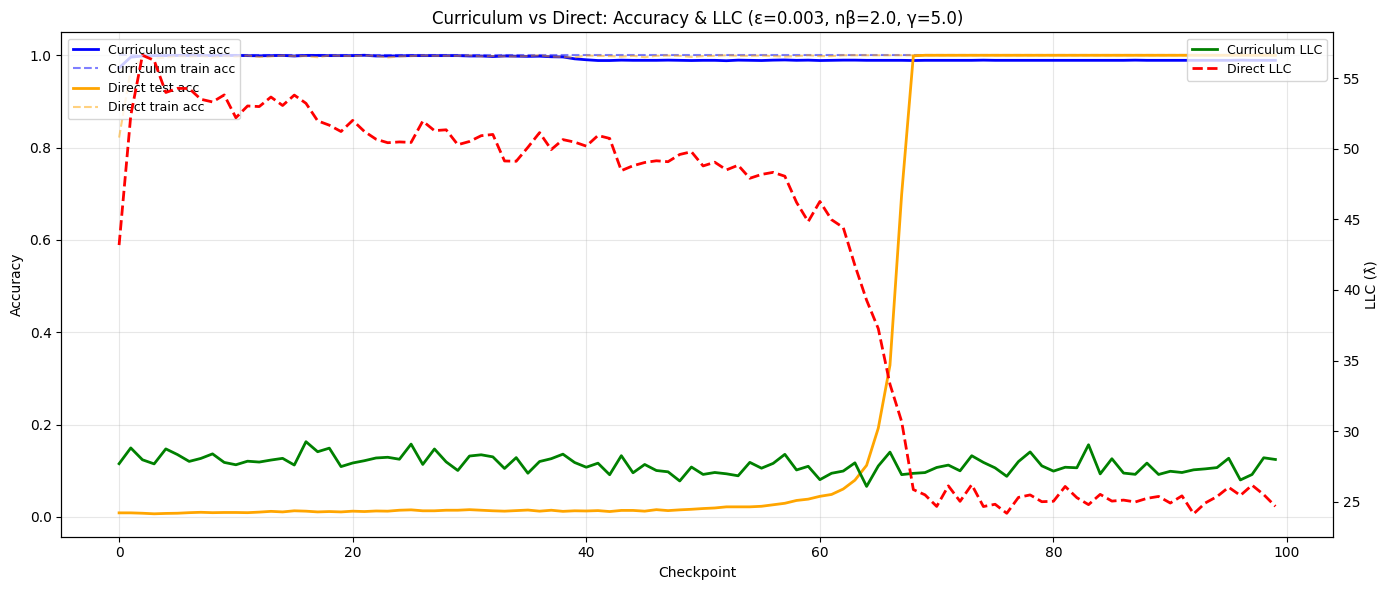

In [15]:
# Comparison: Curriculum Final Stage vs Direct (LLC & Accuracy, seed 0)
seed = SEEDS[0]
fig, ax1 = plt.subplots(figsize=(14, 6))
ax2 = ax1.twinx()

# Curriculum final stage
df_curriculum = curriculum_results[seed][INPUT_RANGES[-1]]['df']
ax1.plot(df_curriculum["val_acc"], label=f"Curriculum test acc", color='blue', linewidth=2)
ax1.plot(df_curriculum["train_acc"], label=f"Curriculum train acc", color='blue', linestyle='--', alpha=0.5)

# Direct training
df_direct = direct_results[seed]['df']
ax1.plot(df_direct["val_acc"], label=f"Direct test acc", color='orange', linewidth=2)
ax1.plot(df_direct["train_acc"], label=f"Direct train acc", color='orange', linestyle='--', alpha=0.5)

# LLC overlay
curriculum_llc_values = [llc["llc/mean"] for llc in curriculum_llcs_by_seed[seed][-1]]
direct_llc_values = [llc["llc/mean"] for llc in direct_llcs_by_seed[seed]]

ax2.plot(curriculum_llc_values, color='green', label="Curriculum LLC", linewidth=2)
ax2.plot(direct_llc_values, color='red', label="Direct LLC", linewidth=2, linestyle='--')

ax1.set_xlabel("Checkpoint")
ax1.set_ylabel("Accuracy")
ax2.set_ylabel("LLC (λ̂)")
ax1.set_title(f"Curriculum vs Direct: Accuracy & LLC (ε={llc_lr}, nβ={llc_nbeta}, γ={llc_gamma})")
ax1.legend(loc='upper left', fontsize=9)
ax2.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)
plt.tight_layout()
save_fig(fig, 'curriculum_vs_direct_accuracy_llc.png')

Saved: curriculum_vs_direct_loss_llc.png


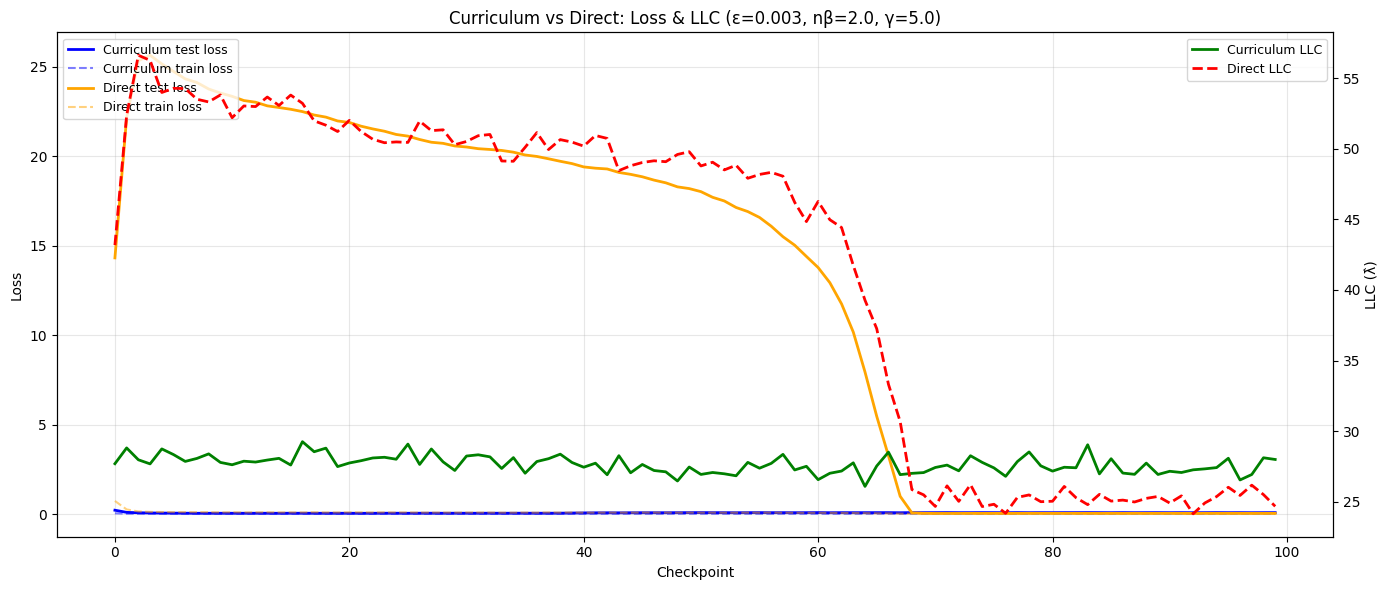

In [16]:
# Comparison: Curriculum Final Stage vs Direct (LLC & Loss, seed 0)
seed = SEEDS[0]
fig, ax1 = plt.subplots(figsize=(14, 6))
ax2 = ax1.twinx()

# Curriculum final stage
df_curriculum = curriculum_results[seed][INPUT_RANGES[-1]]['df']
ax1.plot(df_curriculum["val_loss"], label=f"Curriculum test loss", color='blue', linewidth=2)
ax1.plot(df_curriculum["train_loss"], label=f"Curriculum train loss", color='blue', linestyle='--', alpha=0.5)

# Direct training
df_direct = direct_results[seed]['df']
ax1.plot(df_direct["val_loss"], label=f"Direct test loss", color='orange', linewidth=2)
ax1.plot(df_direct["train_loss"], label=f"Direct train loss", color='orange', linestyle='--', alpha=0.5)

# LLC overlay
curriculum_llc_values = [llc["llc/mean"] for llc in curriculum_llcs_by_seed[seed][-1]]
direct_llc_values = [llc["llc/mean"] for llc in direct_llcs_by_seed[seed]]

ax2.plot(curriculum_llc_values, color='green', label="Curriculum LLC", linewidth=2)
ax2.plot(direct_llc_values, color='red', label="Direct LLC", linewidth=2, linestyle='--')

ax1.set_xlabel("Checkpoint")
ax1.set_ylabel("Loss")
ax2.set_ylabel("LLC (λ̂)")
ax1.set_title(f"Curriculum vs Direct: Loss & LLC (ε={llc_lr}, nβ={llc_nbeta}, γ={llc_gamma})")
ax1.legend(loc='upper left', fontsize=9)
ax2.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)
plt.tight_layout()
save_fig(fig, 'curriculum_vs_direct_loss_llc.png')

Saved: curriculum_stage1_data.csv
  Shape: (100, 8), LLC range: [5.58, 11.14]
  Last 3 rows:
    batch  train_acc   val_acc       llc
97  49000        1.0  0.027027  6.764482
98  49500        1.0  0.027027  6.295083
99  50000        1.0  0.027027  5.578621

Saved: curriculum_stage2_data.csv
  Shape: (100, 8), LLC range: [13.03, 16.68]
  Last 3 rows:
    batch  train_acc   val_acc        llc
97  49000        1.0  0.018868  14.420525
98  49500        1.0  0.018868  14.471042
99  50000        1.0  0.018868  14.146688

Saved: curriculum_stage3_data.csv
  Shape: (100, 8), LLC range: [20.78, 31.73]
  Last 3 rows:
    batch  train_acc   val_acc        llc
97  49000        1.0  0.721582  21.980305
98  49500        1.0  0.734761  21.031830
99  50000        1.0  0.718287  22.096210

Saved: curriculum_stage4_data.csv
  Shape: (100, 8), LLC range: [26.09, 29.26]
  Last 3 rows:
    batch  train_acc   val_acc        llc
97  49000        1.0  0.989015  26.932896
98  49500        1.0  0.989015  28.117

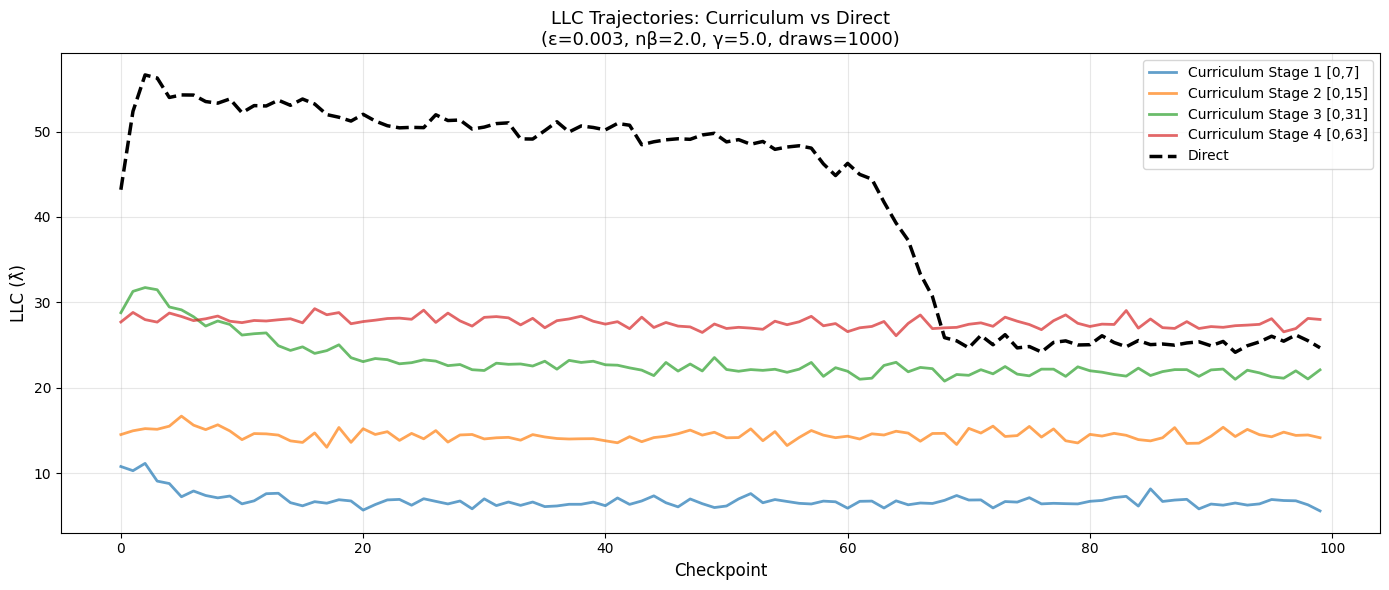


LLC SUMMARY

Curriculum Stage 1 [0,7]:
  Num checkpoints: 100
  Initial LLC: 10.78
  Final LLC:   5.58
  Min LLC:     5.58
  Max LLC:     11.14

Curriculum Stage 2 [0,15]:
  Num checkpoints: 100
  Initial LLC: 14.52
  Final LLC:   14.15
  Min LLC:     13.03
  Max LLC:     16.68

Curriculum Stage 3 [0,31]:
  Num checkpoints: 100
  Initial LLC: 28.78
  Final LLC:   22.10
  Min LLC:     20.78
  Max LLC:     31.73

Curriculum Stage 4 [0,63]:
  Num checkpoints: 100
  Initial LLC: 27.70
  Final LLC:   28.00
  Min LLC:     26.09
  Max LLC:     29.26

Direct Training:
  Num checkpoints: 100
  Initial LLC: 43.18
  Final LLC:   24.68
  Min LLC:     24.15
  Max LLC:     56.62


In [17]:
# Save all data to CSV for inspection (seed 0)
seed = SEEDS[0]

# Save curriculum data
for stage_idx, (stage_llcs, max_val) in enumerate(zip(curriculum_llcs_by_stage, INPUT_RANGES)):
    df = curriculum_results[seed][max_val]['df'].copy()
    df['llc'] = [llc["llc/mean"] for llc in stage_llcs]
    df['stage'] = stage_idx + 1
    df['max_val'] = max_val
    csv_path = RESULTS_DIR / f'curriculum_stage{stage_idx+1}_data.csv'
    df.to_csv(csv_path, index=False)
    print(f"Saved: {csv_path.name}")
    print(f"  Shape: {df.shape}, LLC range: [{df['llc'].min():.2f}, {df['llc'].max():.2f}]")
    print(f"  Last 3 rows:")
    print(df[['batch', 'train_acc', 'val_acc', 'llc']].tail(3))
    print()

# Save direct training data
df_direct = direct_results[seed]['df'].copy()
df_direct['llc'] = [llc["llc/mean"] for llc in direct_llcs]
csv_path = RESULTS_DIR / 'direct_training_data.csv'
df_direct.to_csv(csv_path, index=False)
print(f"Saved: {csv_path.name}")
print(f"  Shape: {df_direct.shape}, LLC range: [{df_direct['llc'].min():.2f}, {df_direct['llc'].max():.2f}]")

# Comparison: Curriculum vs Direct (LLC Trajectories, seed 0)
fig = plt.figure(figsize=(14, 6))

# Plot each curriculum stage
for stage_idx, (stage_llcs, max_val) in enumerate(zip(curriculum_llcs_by_stage, INPUT_RANGES)):
    llc_values = [llc["llc/mean"] for llc in stage_llcs]
    checkpoints = np.arange(len(llc_values))
    
    plt.plot(checkpoints, llc_values, 
             label=f"Curriculum Stage {stage_idx+1} [0,{max_val}]", 
             linewidth=2,
             alpha=0.7)

# Plot direct training
direct_llc_values = [llc["llc/mean"] for llc in direct_llcs]
direct_checkpoints = np.arange(len(direct_llc_values))

plt.plot(direct_checkpoints, direct_llc_values, 
         label="Direct", 
         linewidth=2.5,
         linestyle='--',
         color='black')

plt.xlabel("Checkpoint", fontsize=12)
plt.ylabel("LLC (λ̂)", fontsize=12)
plt.title(f"LLC Trajectories: Curriculum vs Direct\n(ε={llc_lr}, nβ={llc_nbeta}, γ={llc_gamma}, draws={llc_num_draws})", fontsize=13)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
save_fig(fig, 'llc_trajectories_comparison.png')

# Summary statistics
print("\n" + "="*80)
print("LLC SUMMARY")
print("="*80)
for stage_idx, (stage_llcs, max_val) in enumerate(zip(curriculum_llcs_by_stage, INPUT_RANGES)):
    llc_values = [llc["llc/mean"] for llc in stage_llcs]
    
    print(f"\nCurriculum Stage {stage_idx+1} [0,{max_val}]:")
    print(f"  Num checkpoints: {len(llc_values)}")
    print(f"  Initial LLC: {llc_values[0]:.2f}")
    print(f"  Final LLC:   {llc_values[-1]:.2f}")
    print(f"  Min LLC:     {min(llc_values):.2f}")
    print(f"  Max LLC:     {max(llc_values):.2f}")

direct_llc_values = [llc["llc/mean"] for llc in direct_llcs]

print(f"\nDirect Training:")
print(f"  Num checkpoints: {len(direct_llc_values)}")
print(f"  Initial LLC: {direct_llc_values[0]:.2f}")
print(f"  Final LLC:   {direct_llc_values[-1]:.2f}")
print(f"  Min LLC:     {min(direct_llc_values):.2f}")
print(f"  Max LLC:     {max(direct_llc_values):.2f}")
print("="*80)

## 10. Summary

This notebook demonstrates TRUE curriculum learning where:

✅ All stages compute the same function `(a+b) % 64`

✅ Earlier stages are proper subsets of later stages

✅ Same model architecture throughout (no resizing!)

✅ 100% weight transfer between stages

✅ Progressive difficulty via expanding input space

✅ Fair comparison with equalized training budgets

✅ LLC analysis reveals how model complexity evolves during curriculum vs direct learning
